Time Series Forecast with TFT on the Vierlinden dataset (all sensors, 2021)

In [1]:
import sys
sys.path.append('./pytorch-forecasting/')
import pandas as pd
import time
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
pl.seed_everything(42)

Global seed set to 42


42

### Load data

Split in train and validation

In [2]:
# Read the dataset into a DataFrame
data = pd.read_csv('./RIWWER/Vierlinden/Vierlinden_2021_All.csv')

# Drop columns that have lots of missing values
data.drop(["FLP_Hohenstand_Pumpensumpf_pval","FLP_Strom_P3_pval","FLP_Strom_P4_pval","FLP_Strom_P5_pval","Durchfluss SWP1 und SWP2_pval","FLP_Hohenstand_Becken1_pval","FLP_Hohenstand_Becken3_pval","FLP_Hohenstand_Beckne2_pval"], axis=1, inplace=True)

# NaNs are not allowed by the model
data.fillna(method="bfill", inplace=True)
data.fillna(method="ffill", inplace=True)

# Set Datetime as index
data['Datetime'] = pd.to_datetime(data['Datetime'])

In [3]:
# One time series for the whole year?
data['series'] = 0

# As many timesteps per timeseries as hours in every month?
time_idx = []
for i in range(1):
    timesteps = len( data[ data['series'] == i ] )
    time_idx += list(range(timesteps))
data['time_idx'] = time_idx
data

,Datetime,Schieber Position_pval,Oberwasser_pval,Unterwasser_pval,Durchflumenge_pval,Berechnete Durchflussmenge_pval,Fllstand SWS_pval,Fllstand RWS_pval,Strom P1_pval,Strom P2_pval,...,Strom Pumpe 2_pval1,Strom Pumpe 3_pval,Niederschlag,Füllstand_RRB,Entleerung_RüB,Füllstand_RüB_1,Füllstand_RüB_2,Füllstand_RüB_3,series,time_idx
0,2021-01-01 00:00:00,100.0,8.140845,5.753623,7.689189,7.732558,75.717949,36.0,1.076923,0.0,...,0.0,1.0,0.000000,1.47,0.098,3.16,3.08,2.72,0,0
1,2021-01-01 01:00:00,100.0,8.000000,5.173913,6.808219,8.271739,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.099,3.16,3.08,2.72,0,1
2,2021-01-01 02:00:00,100.0,7.967742,5.000000,5.813333,7.197674,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.096,3.16,3.08,2.72,0,2
3,2021-01-01 03:00:00,100.0,7.076923,4.843750,4.216216,4.743243,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.098,3.16,3.08,2.72,0,3
4,2021-01-01 04:00:00,100.0,8.464789,5.466667,8.384615,8.325000,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.098,3.16,3.08,2.72,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31 19:00:00,99.0,9.859155,6.147541,9.347222,12.800000,75.033333,35.0,1.700000,0.0,...,0.0,1.0,0.000000,1.06,0.181,1.15,1.29,0.62,0,8755
8756,2021-12-31 20:00:00,99.0,9.111111,5.823529,7.970588,11.211268,76.000000,35.0,1.300000,0.0,...,0.0,1.0,0.000000,1.06,0.179,1.15,1.29,0.62,0,8756
8757,2021-12-31 21:00:00,99.0,11.652778,7.544118,16.804878,17.802326,74.250000,35.0,1.600000,0.0,...,0.0,1.0,0.000000,1.06,0.183,1.15,1.29,0.62,0,8757
8758,2021-12-31 22:00:00,99.0,8.338028,5.287671,7.107692,9.878788,76.200000,35.0,1.233333,0.0,...,0.0,1.0,0.000000,1.06,0.186,1.15,1.29,0.62,0,8758


In [4]:
# Create dataloaders
max_encoder_length = 24*2
max_prediction_length = 5*2
training_cutoff = data["time_idx"].max() * 4 // 5 # 80% for training
# Note: if you just subtract 1*max_prediction_length, some of the time series (for some of the months) will not be computed

context_length = max_encoder_length
prediction_length = max_prediction_length

# Note: NBeats can only handle one target
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    target_normalizer="auto",
    time_idx="time_idx",
    target="Entleerung_RüB",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=list(set(data.columns) - {'Datetime', 'series', 'time_idx'}),
    time_varying_known_reals=['time_idx'],
    max_encoder_length=context_length,
    min_encoder_length=max_encoder_length,
    max_prediction_length=prediction_length,
    min_prediction_length=max_prediction_length,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 32
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=18)

### Load models and predict

In [5]:
models_base_path = './RIWWER/torch_forecasting/model_checkpoints/'
model_names = ['TFT_Vierlinden', 'TFT_Vierlinden_QL', 'NHits_Vierlinden', 'NHits_Vierlinden_QL']
model_paths = [
    models_base_path + model_names[0] + '/lightning_logs/version_0/checkpoints/epoch=21-step=3300.ckpt',
    models_base_path + model_names[1] + '/lightning_logs/version_3/checkpoints/epoch=21-step=3300.ckpt',
    models_base_path + model_names[2] + '/lightning_logs/version_0/checkpoints/epoch=14-step=2250.ckpt',
    models_base_path + model_names[3] + '/lightning_logs/version_2/checkpoints/epoch=99-step=15000.ckpt'
]

In [6]:
best_models = {}
for mp, mn in zip(model_paths, model_names):
    if 'TFT' in mn:
        best_models[mn] = TemporalFusionTransformer.load_from_checkpoint(mp)
    else:
        best_models[mn] = NHiTS.load_from_checkpoint(mp)

/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [29]:
# Compute latency (inference time per sample)
val_size = len(val_dataloader.__dict__['dataset'])
for i, mn in enumerate(best_models):
    start_time = time.time()
    raw_predictions = best_models[mn].predict(val_dataloader, mode="raw", return_x=True,
                                         trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/" + mn))
    print('\n' + mn + ':')
    print("--- %s ms / sample ---" % ((time.time() - start_time) * 1000 / val_size))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



TFT_Vierlinden:
--- 1.2992801710031392 ms / sample ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



TFT_Vierlinden_QL:
--- 1.4841298022902156 ms / sample ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



NHits_Vierlinden:
--- 1.0940285845180386 ms / sample ---

NHits_Vierlinden_QL:
--- 1.161869271213271 ms / sample ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TFT_Vierlinden


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TFT_Vierlinden_QL


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


NHits_Vierlinden
NHits_Vierlinden_QL


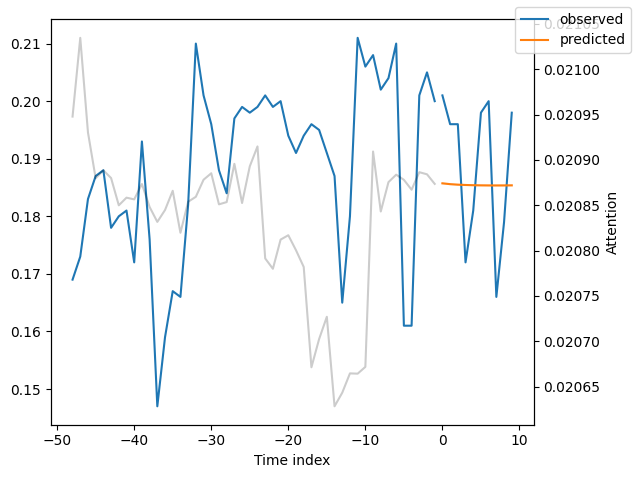

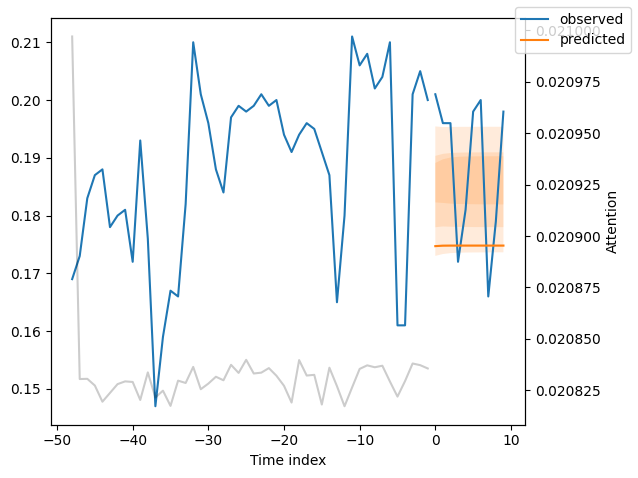

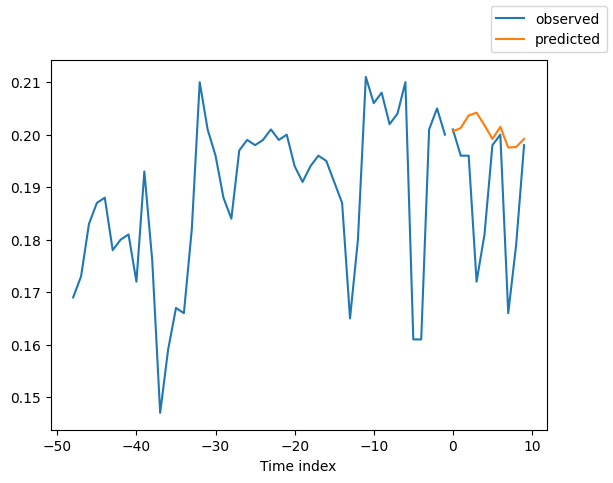

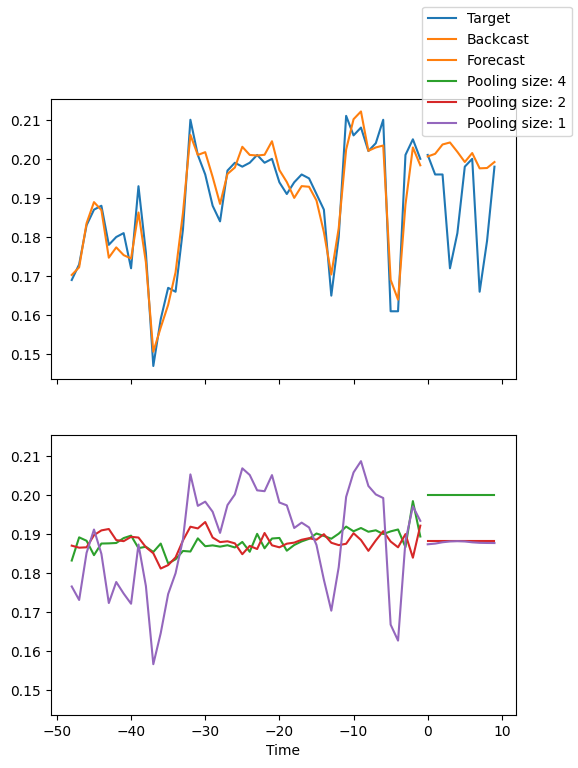

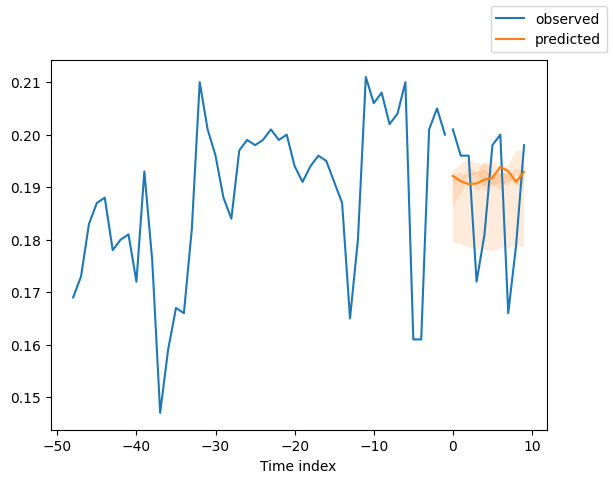

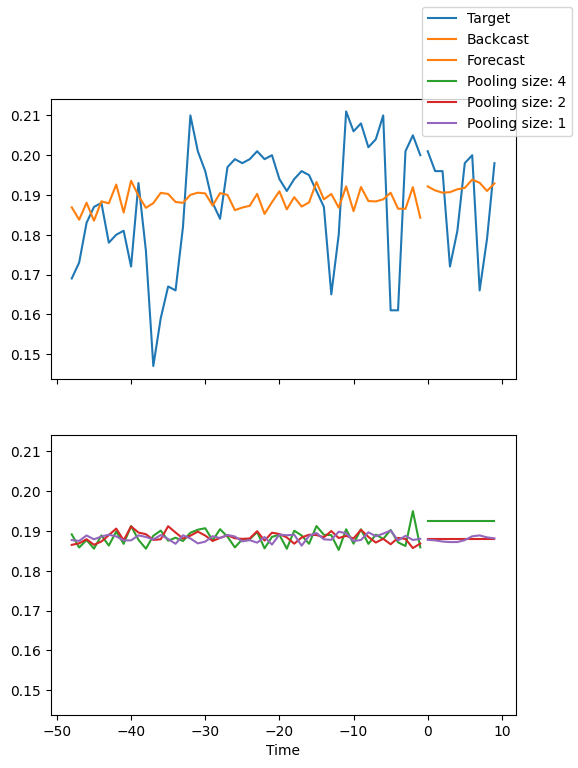

In [7]:
# Visualize predictions and explanations for one sample
sample_id = 0
for i, mn in enumerate(best_models):
    raw_predictions = best_models[mn].predict(val_dataloader, mode="raw", return_x=True,
                                         trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/" + mn))
    print(mn)
    best_models[mn].plot_prediction(raw_predictions.x, raw_predictions.output,
                                    idx=sample_id, add_loss_to_title=False);
    if 'NHits' in mn:
        best_models[mn].plot_interpretation(raw_predictions.x, raw_predictions.output, idx=sample_id);